In [1]:
import datetime
from nowtrade.symbol_list import StockList
from nowtrade.data_connection import MongoDatabaseConnection
from nowtrade.dataset import Dataset
from nowtrade.technical_indicator import SMA, EMA, RSI, BBANDS, STOCH, STOCHF 
from nowtrade.criteria import CrossingAbove
from nowtrade.criteria import TrailingStop
from nowtrade.criteria_group import CriteriaGroup
from nowtrade.action import Long
from nowtrade.action import LongExit
from nowtrade.trading_profile import TradingProfile
from nowtrade.trading_amount import StaticAmount
from nowtrade.trading_fee import StaticFee
from nowtrade.strategy import Strategy
from nowtrade import technical_indicator
from nowtrade import criteria

In [2]:
# Create our stock list to inform our data connection which stocks to retrieve
stocks = StockList(['GOOGL'])
# We can now use this variable to reference our stock when defining enter/exit criteria
googl = stocks.get('GOOGL')
# Specify our start and end dates for this backtest
start = datetime.datetime(2010, 01, 01)
end = datetime.datetime(2017, 05, 01)
# Create the dataset that will hold all of the stock data
stock_data = Dataset(stocks, MongoDatabaseConnection(), start, end)

In [3]:
stock_data.load_data()

In [4]:
sma50 = SMA(googl.close, 50)
# 100-day simple moving average of GOOGL close prices
sma100 = SMA(googl.close, 100)
# Now that we've defined our technical indicators, we need to apply them to our dataset
stock_data.add_technical_indicator(sma50)
stock_data.add_technical_indicator(sma100)

/anaconda/lib/python2.7/site-packages/nowtrade/technical_indicator.py:253: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  data_frame[self.value] = pd.rolling_mean(data_frame[self.data], self.period)
/anaconda/lib/python2.7/site-packages/nowtrade/technical_indicator.py:253: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  data_frame[self.value] = pd.rolling_mean(data_frame[self.data], self.period)


In [5]:
bbands50 = BBANDS(googl.close,50)
ema50=EMA(googl.close,50)
rsi50=RSI(googl.close,50)
stoch_=STOCH(googl)
stochf_=STOCHF(googl)
# Now that we've defined our technical indicators, we need to apply them to our dataset
stock_data.add_technical_indicator(bbands50)
stock_data.add_technical_indicator(ema50)
stock_data.add_technical_indicator(rsi50)
stock_data.add_technical_indicator(stoch_)
stock_data.add_technical_indicator(stochf_)

In [6]:
import pandas as pd

In [7]:
sma1=sma50.value
sma2=sma100.value
bbands=bbands50.value
ema=ema50.value
rsi=rsi50.value
stoch=stoch_.value
stochf=stochf_.value

In [8]:
z=pd.DataFrame(stock_data.data_frame[295:].loc[:,['GOOGL_Close',sma1,sma2,bbands,ema,rsi,stoch,stochf]])

In [9]:
z.columns=['GOOGL_Close','SMA_50','SMA_100','BBANDS','EMA','RSI','STOCH','STOCHF']

In [10]:
z.head()

,GOOGL_Close,SMA_50,SMA_100,BBANDS,EMA,RSI,STOCH,STOCHF
Date,,,,,,,,
2011-03-07,591.660014,612.634613,605.164109,626.386235,608.260791,49.458421,32.286678,14.463091
2011-03-08,592.309998,612.396213,605.654209,626.566591,607.635270,49.585629,19.580686,21.682279
2011-03-09,591.770011,612.184013,606.162609,626.704942,607.013103,49.480057,19.844338,23.387643
2011-03-10,580.299986,611.811612,605.951108,626.796008,605.965530,47.297401,15.982759,2.878357
2011-03-11,576.710013,611.325812,605.541109,626.834691,604.818255,46.640323,12.466334,11.133004


In [23]:
# Criteria
symbol=googl
from nowtrade import criteria_group, strategy, trading_profile, trading_amount, trading_fee
from nowtrade.action import Short, ShortExit
enter_crit_long1 = criteria.Above(rsi50.value, 60)
enter_crit_long3 = criteria.Above(ema50.value, 60)
# SMA100 slope is moving up
enter_crit_long2 = criteria.Above(sma50.value, sma100.value)
enter_crit_short1 = criteria.Below(rsi50.value, 40)
# SMA100 slope is moving down
enter_crit_short2 = criteria.Below(sma50.value, sma100.value)
enter_crit_short3 = criteria.Below(ema50.value, 40)
# Stop loss and take profit exit criteria
exit_crit_long1 = criteria.StopLoss(symbol, 0.01, percent=True) # 1%
exit_crit_long2 = criteria.TakeProfit(symbol, 50) # $100
exit_crit_short1 = criteria.StopLoss(symbol, 0.01, short=True, percent=True) # 1%
exit_crit_short2 = criteria.TakeProfit(symbol, 50, short=True) # $100
# Criteria Groups
enter_crit_group1 = criteria_group.CriteriaGroup([enter_crit_long1, enter_crit_long2, enter_crit_long3], Long(), symbol)
enter_crit_group2 = criteria_group.CriteriaGroup([enter_crit_short1, enter_crit_short2, enter_crit_short3], Short(), symbol)
exit_crit_group1 = criteria_group.CriteriaGroup([exit_crit_long1], LongExit(), symbol)
exit_crit_group2 = criteria_group.CriteriaGroup([exit_crit_long2], LongExit(), symbol)
exit_crit_group3 = criteria_group.CriteriaGroup([exit_crit_short1], ShortExit(), symbol)
exit_crit_group4 = criteria_group.CriteriaGroup([exit_crit_short2], ShortExit(), symbol)

In [24]:
tp = trading_profile.TradingProfile(20000, trading_amount.StaticAmount(10000), trading_fee.StaticFee(5))
strat = strategy.Strategy(stock_data, [enter_crit_group1, enter_crit_group2, exit_crit_group1, exit_crit_group2, exit_crit_group3, exit_crit_group4], tp)
strat.simulate()

In [25]:
print strat.report.pretty_overview()

Trades:
GOOGL
Trade(datetime=2010-10-18 00:00:00, action=LONG, symbol=GOOGL, price=600.54998, shares=17.0, money=10209.34966, fee=5, slippage=0.0)
Trade(datetime=2010-10-19 00:00:00, action=LONG_EXIT, symbol=GOOGL, price=608.850021, shares=17.0, money=10350.450357, fee=5, slippage=0.0)
Trade(datetime=2010-10-20 00:00:00, action=LONG, symbol=GOOGL, price=608.139977, shares=16.0, money=9730.239632, fee=5, slippage=0.0)
Trade(datetime=2010-10-22 00:00:00, action=LONG_EXIT, symbol=GOOGL, price=611.920007, shares=16.0, money=9790.720112, fee=5, slippage=0.0)
Trade(datetime=2010-10-25 00:00:00, action=LONG, symbol=GOOGL, price=615.589979, shares=16.0, money=9849.439664, fee=5, slippage=0.0)
Trade(datetime=2010-11-04 00:00:00, action=LONG_EXIT, symbol=GOOGL, price=624.640002, shares=16.0, money=9994.240032, fee=5, slippage=0.0)
Trade(datetime=2010-11-05 00:00:00, action=LONG, symbol=GOOGL, price=623.180037, shares=16.0, money=9970.880592, fee=5, slippage=0.0)
Trade(datetime=2010-11-09 00:00:0

In [14]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

In [15]:
mms=MinMaxScaler()

In [16]:
zy=pd.DataFrame(mms.fit_transform(z))

In [17]:
zy.columns=z.columns

In [18]:
zy=zy.set_index(z.index)

In [19]:
zy.head()

,GOOGL_Close,SMA_50,SMA_100,BBANDS,EMA,RSI,STOCH,STOCHF
Date,,,,,,,,
2011-03-07,0.156691,0.143025,0.117587,0.199366,0.136719,0.557283,0.318719,0.144631
2011-03-08,0.157563,0.142664,0.118413,0.199614,0.135762,0.560032,0.189668,0.216823
2011-03-09,0.156838,0.142343,0.119270,0.199804,0.134811,0.557751,0.192346,0.233876
2011-03-10,0.141448,0.141780,0.118913,0.199930,0.133209,0.510579,0.153125,0.028784
2011-03-11,0.136631,0.141045,0.118222,0.199983,0.131454,0.496378,0.117410,0.111330


In [20]:
%matplotlib inline

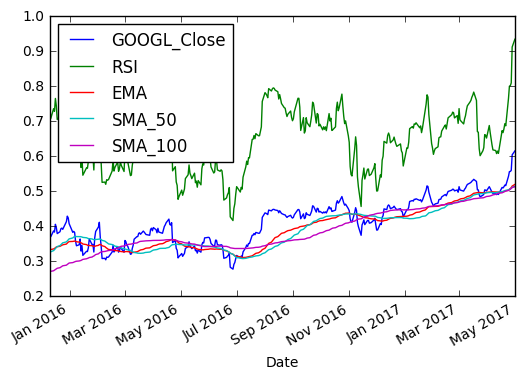

In [21]:
zy[1200:][['GOOGL_Close','RSI','EMA','SMA_50','SMA_100']].plot()

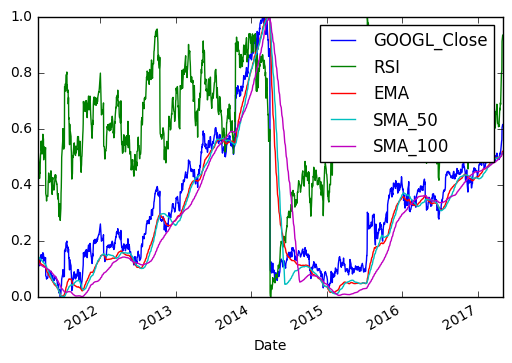

In [22]:
zy[['GOOGL_Close','RSI','EMA','SMA_50','SMA_100']].plot()